In [ ]:
# default_exp core

In [ ]:
%load_ext autoreload
%autoreload 2

# Dataset

> Extract and align frames from videos.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
from itertools import chain, repeat
from seeing_through_water.core import *
from tqdm.notebook import tqdm
from fastcore.all import *
import numpy as np
from scipy.signal import spectrogram, find_peaks, butter, filtfilt, hilbert
import matplotlib.pyplot as plt
from fastpapers.core import *
from fastai.data.all import *
from fastai.vision.all import *

## Load Data

In [ ]:
ds = 'val'
videos, fnames = videos_source.get_subset(ds)

## Calibration

First we extract one video to calibrate the frames.

In [ ]:
video = videos_source.one_video()
frame = brightest_frame(video, max_iter=100)
c = Calibrator(frame)
c.display()

## Find Images

To find all the images we look for peaks in intensity. We use the Fourier transform to find the presentation frequency and filter the signal before running the peak detection algorithm.

In [ ]:
mean_vals = []
for vf in videos:
    for frame in eager_video_iterator(vf):
        mean_vals.append(c.crop_array(frame).mean())
mean_vals = np.array(mean_vals)

peak frequency: 3.997Hz


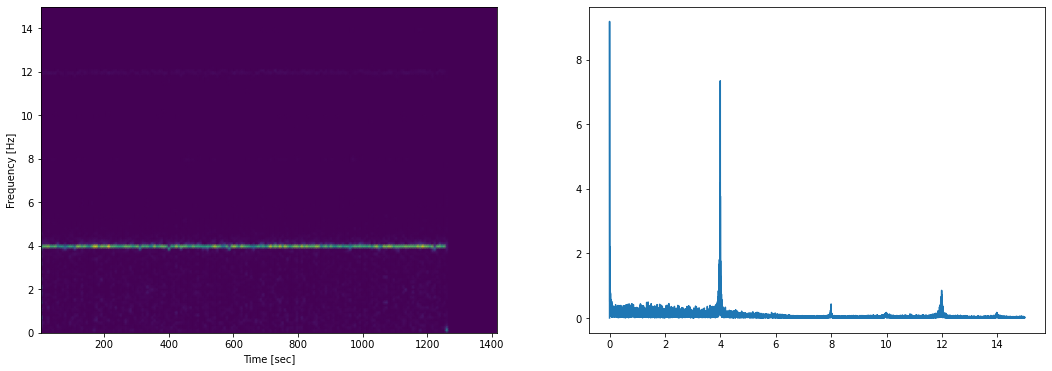

In [ ]:
y = mean_vals-mean_vals.mean()
_, fr = video_info(vf)
N = len(mean_vals)
x = np.linspace(0.0, N/fr, N)

f, t, Sxx = spectrogram(y, fr)
xf, yf = xy_fft(x, y)
fig, axs = plt.subplots(1,2,figsize=(18, 6))
axs[0].pcolormesh(t, f, Sxx, shading='gouraud')
axs[0].set_ylabel('Frequency [Hz]')
axs[0].set_xlabel('Time [sec]')
axs[1].plot(xf, yf)
peak_freq = xf[yf[4:].argmax()+4]
print(f'peak frequency: {peak_freq:2.4}Hz')

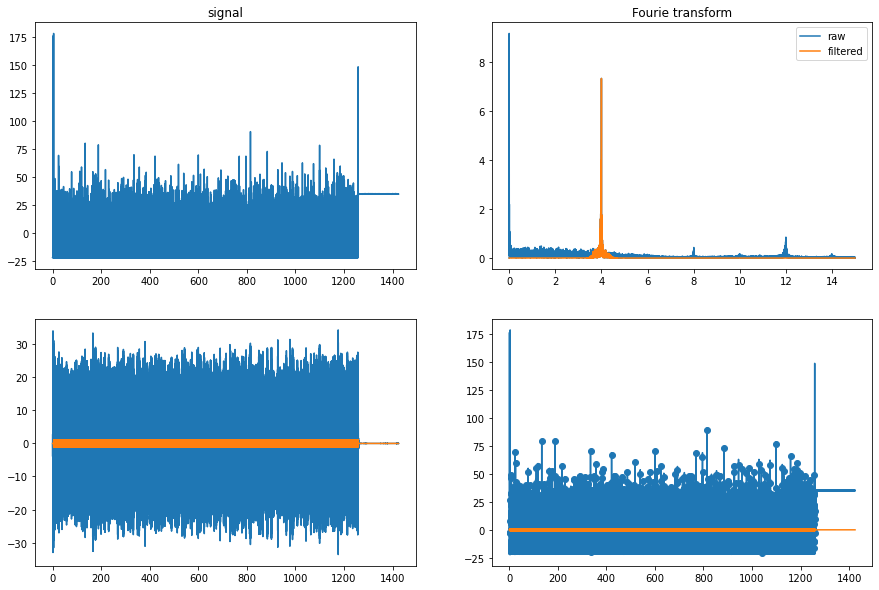

number of peaks: 5000, number of images to match: 5000


In [ ]:
plt.close('all')
peaks, _ = find_peaks(y, distance=len(y)/4, height=100)
[iniy, endy] = peaks[:2]
N = len(mean_vals)
x = np.linspace(0.0, N/fr, N)
fig, axs = plt.subplots(2,2, figsize=(15, 10))
axs[0, 0].plot(x, y)
axs[0, 0].set_title('signal')

xf, yf = xy_fft(x, y)

b, a = butter(4, [peak_freq*0.9/max(xf), peak_freq*1.1/max(xf)], btype='bandpass')
yfilt = filtfilt(b, a, y, padlen=150)
analytic_signal = hilbert(yfilt)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
yfilth = np.cos(instantaneous_phase)
yfilth[:iniy+2] = 0
yfilth[endy-2:] = 0
_, yfiltf = xy_fft(x, yfilt)

axs[0, 1].plot(xf, yf, label='raw')
axs[0, 1].plot(xf, yfiltf, label='filtered')
axs[0, 1].set_title('Fourie transform')
axs[0, 1].legend()

yfiltn = yfilt/yfilt.max()
peaks, _ = find_peaks(yfilth, distance=7,height=0.5)

axs[1, 0].plot(x, yfilt)
axs[1, 0].plot(x, yfilth)

axs[1, 1].plot(x, y)
axs[1, 1].plot(x, yfilth)
axs[1, 1].scatter(x[peaks], y[peaks])
plt.show()
print(f'number of peaks: {len(peaks)}, number of images to match: {len(fnames)}')

## Extract frames

In [ ]:
def key_frames_iter(videos, peaks, reps=1):
    assert reps%2==1
    width = (reps-1)/2
    i = 0
    for vf in videos:
        for frame in eager_video_iterator(vf):
            if np.abs(peaks-i).min()<=width: yield frame
            i+=1

In [ ]:
sample_frames = []
for i, x in enumerate(key_frames_iter(videos, peaks, 3)):
    sample_frames.append(x)
    if i>50:
        break

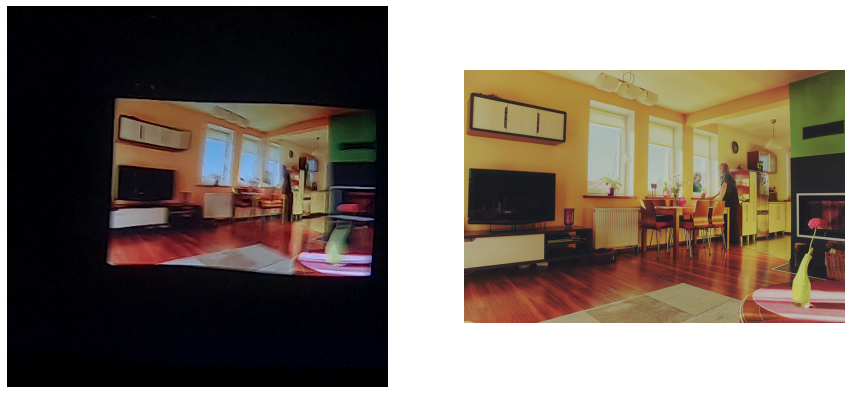

In [ ]:
i = 0
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
show_image(c.crop_array(sample_frames[i])[..., ::-1], ax=axs[0])
show_image(Image.open(fnames[i]), ax=axs[1]);

## Side to side calibration

In [ ]:
bc = BrowserCalibrator(sample_frames, fnames, reps=3, min_sz=300, max_sz=400, min_cl=700, max_cl=800, min_ct=450, max_ct=550)
bc.display()

## Create data set

In [ ]:
reps = 3
dst_folder = fnames[0].parent.parent.parent / f'coco_under_water3_test/{ds}2017'
if not dst_folder.exists():
    dst_folder.mkdir(parents=True)

rfnames = zip(chain(*zip(*repeat(fnames, reps))), cycle(range(reps)))

for i, (img, (fname, fidx)) in enumerate(zip(key_frames_iter(videos, peaks, reps), tqdm(rfnames))):
    dst = dst_folder/ f'{fidx}' /  fname.name
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True)
    img = bc.encode(img, reference=PILImage.create(fname))
    img.save(dst)